In [1]:
from glob import glob

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calculate_moments(image):
    mean = np.mean(image)
    std_dev = np.std(image)
    skewness = np.mean((image - mean) ** 3) / (std_dev ** 3)
    kurtosis = np.mean((image - mean) ** 4) / (std_dev ** 4) - 3
    
    return mean, std_dev, skewness, kurtosis

In [3]:
def extract_color_features(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract moments for each HSV component
    h_mean, h_std, h_skewness, h_kurtosis = calculate_moments(hsv_image[:,:,0])
    s_mean, s_std, s_skewness, s_kurtosis = calculate_moments(hsv_image[:,:,1])
    v_mean, v_std, v_skewness, v_kurtosis = calculate_moments(hsv_image[:,:,2])

    return [h_mean, h_std, h_skewness, h_kurtosis,
            s_mean, s_std, s_skewness, s_kurtosis,
            v_mean, v_std, v_skewness, v_kurtosis]

In [4]:
def extract_shape_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Sobel operators to obtain the gradient image
    gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = 3)
    gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = 3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Normalize gradient image to [0, 1]
    gradient_normalized = cv2.normalize(gradient_magnitude, None, 0, 1, cv2.NORM_MINMAX)

    return gradient_normalized

In [5]:
def extract_ring_features(gradient_image, num_rings = 5, num_bins = 36):
    # Divide the image into concentric rings
    height, width = gradient_image.shape
    center = (width // 2, height // 2)
    max_radius = min(center[0], center[1])

    ring_features = []

    for i in range(1, num_rings + 1):
        # Calculate ring boundaries
        inner_radius = max_radius * (i - 1) / num_rings
        outer_radius = max_radius * i / num_rings

        # Extract pixels within the ring
        ring_pixels = cv2.getRectSubPix(gradient_image, (int(outer_radius * 2), int(outer_radius * 2)), center)
        ring_pixels = cv2.getRectSubPix(ring_pixels, (int(inner_radius * 2), int(inner_radius * 2)), (outer_radius, outer_radius))

        # Calculate moments for ring edge magnitudes
        ring_mean, ring_std, ring_skewness, ring_kurtosis = calculate_moments(ring_pixels)
        ring_features.extend([ring_mean, ring_std, ring_skewness, ring_kurtosis])

        # Calculate normalized polar histogram for the ring
        gradient_x = cv2.Sobel(gradient_image, cv2.CV_64F, 1, 0, ksize = 3)
        gradient_y = cv2.Sobel(gradient_image, cv2.CV_64F, 0, 1, ksize = 3)

        _, edge_orientation = cv2.cartToPolar(gradient_x, gradient_y)
        ring_histogram = np.histogram(edge_orientation, bins=np.linspace(0, 2*np.pi, num_bins + 1), weights = ring_pixels)[0]
        ring_histogram /= np.sum(ring_histogram)  # Normalize the histogram
        ring_features.extend(ring_histogram)

    return ring_features

In [6]:
# Image directories
nickels_cropped_dir = "./nickels_cropped/"
nickels_cropped_files = glob(f"{nickels_cropped_dir}/*")

quarters_cropped_dir = "./quarters_cropped/"
quarters_cropped_files = glob(f"{quarters_cropped_dir}/*")

cents_cropped_dir = "./cents_cropped/"
cents_cropped_files = glob(f"{cents_cropped_dir}/*")

In [7]:
img = np.asarray(Image.open(quarters_cropped_files[0]))

color_features = extract_color_features(img)
shape_features = extract_shape_features(img)

In [8]:
ring_features = extract_ring_features(shape_features)

error: OpenCV(4.6.0) /croot/opencv-suite_1691620365762/work/modules/imgproc/src/samplers.cpp:420: error: (-210:Unsupported format or combination of formats) Unsupported combination of input and output formats in function 'getRectSubPix'


In [9]:
def calculate_shape_features(gradient_image):
    # Define the concentric circular rings
    ring_radii = [10, 20, 30, 40, 50]

    shape_features = []

    for radius in ring_radii:
        # Extract pixels within the circular ring
        ring_mask = np.zeros_like(gradient_image, dtype=np.uint8)
        cv2.circle(ring_mask, (gradient_image.shape[1] // 2, gradient_image.shape[0] // 2),
                   radius, 255, thickness=-1)
        ring_pixels = cv2.bitwise_and(gradient_image, gradient_image, mask=ring_mask)

        # Calculate mean, std, skewness, and kurtosis of edge magnitudes
        ring_moments = cv2.moments(ring_pixels)
        shape_features.extend([ring_moments['m00'], ring_moments['m10'], ring_moments['m01'],
                               ring_moments['m20'], ring_moments['m11'], ring_moments['m02'],
                               ring_moments['m30'], ring_moments['m21'], ring_moments['m12'],
                               ring_moments['m03']])

        # Calculate normalized polar histogram for edge orientations
        ring_orientations = np.arctan2(cv2.Sobel(ring_pixels, cv2.CV_64F, 1, 0, ksize=3),
                                       cv2.Sobel(ring_pixels, cv2.CV_64F, 0, 1, ksize=3))
        normalized_polar_histogram_ring = np.histogram(ring_orientations, bins=36,
                                                       range=(-np.pi, np.pi), density=True)[0]

        # Append the normalized polar histogram features for each ring
        shape_features.extend(normalized_polar_histogram_ring)

    return shape_features

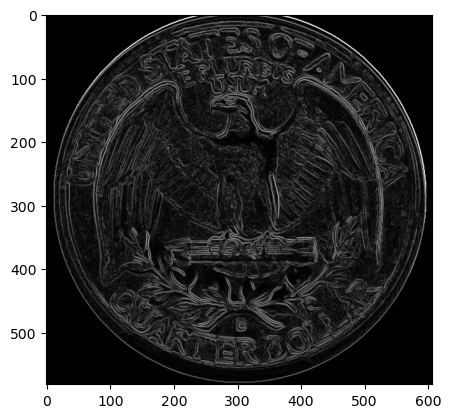

In [10]:
# Load the image
image = cv2.imread(quarters_cropped_files[0])

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Extract edge magnitudes and orientations
sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitudes = np.sqrt(sobel_x**2 + sobel_y**2)
edge_orientations = np.arctan2(sobel_y, sobel_x)

# Normalize the [min, max] range of the gradient magnitudes to [0, 1]
gradient_magnitudes_normalized = cv2.normalize(gradient_magnitudes, None, 0, 1, cv2.NORM_MINMAX)

# Calculate shape features
shape_features = calculate_shape_features(gradient_magnitudes_normalized)

# Perform L1 or L2 distance measures and other steps for rotation angle and polar similarity score
# These steps depend on the specific requirements of your application.

# Display the results if needed
plt.imshow(gradient_magnitudes_normalized, cmap = "gray")